In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

###### Plan:
- Remove the NaN and playername column 
- Plot a bar chart to identify if their is any relational order for tbe categorical variable based on my subject matter knowledge
- Stepwise Regression: Use the P-value and Adjusted R squared to select features, that is, build the model
- Identify the most important predictor variable from the selected ones from above using the standardized method
- Check for Regression Assumptions
* Linearity(Correct Functional form): Trial and error since specifying a regression model is an iterative process
* No Multicollinearity; use VIF
* Independent Error Terms has been automatically checked since it's not a time series data
* Normality of Erros
* Homoscedasticity ; Constant error variance
* One bar plot each to visualize relationship between the dependent variable and independent variable
* Assume that the linear regression assumptions are met
* So all in, then backward elimination
* Based on the remaining parameters, we would now run the assumptions in order to improve the model

In [5]:
footballData = pd.read_csv('footballData.csv')
footballData.head(3)

,Player name,Position,Age,Market Value,NaN,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off
0,Kylian Mbappé,Right Winger,20,200,0,30,24,0,13,4,0,1,5,5
1,Lionel Messi,Right Winger,31,160,0,26,27,0,17,1,0,0,3,1
2,Harry Kane,Centre-Forward,25,150,0,36,21,0,9,5,0,0,4,5


In [6]:
footballData = footballData.drop(['Player name', 'NaN'], axis = 1)

In [7]:
footballData.head(3)

,Position,Age,Market Value,Matches,Goals,Own Goals,Assists,Yellow cards,Second Yellow card,Red Cards,Substitued on,Substituted off
0,Right Winger,20,200,30,24,0,13,4,0,1,5,5
1,Right Winger,31,160,26,27,0,17,1,0,0,3,1
2,Centre-Forward,25,150,36,21,0,9,5,0,0,4,5


The dataset has 12 columns; 11 independent variables and 1 dependent variable which is the market value. This is a regression problem because the value being predicted is a continuous numeric value. From the 11 independent variables, only one categorical variable is present while the remaining 10 are numerical variables. Categorical variables need to be encoded since Machine learning models are based on mathematical equations. Due to knowledge about the subject matter, a bar chat showing the relationship between the categoical variable and the numerical variable will be plotted to establish if their is a relational order in the categorical variable.

In [13]:
#Creating a list of list containing the Positions and the corresponding Market Value
position = footballData['Position']
marketValue = footballData['Market Value']
posMar = pd.concat((position, marketValue), axis = 1, ignore_index = True)
posMar = posMar.to_dict('split')
listPosMar = posMar['data']
listPosMar[:3]

[['Right Winger', 200L], ['Right Winger', 160L], ['Centre-Forward', 150L]]

In [14]:
#Creating a dictionary to store the total market value for each unique position
dicPosMar = {}
for i in range(len(listPosMar)):
    if listPosMar[i][0] in dicPosMar.keys():
        dicPosMar[listPosMar[i][0]] += listPosMar[i][1]
    else:
        dicPosMar[listPosMar[i][0]] = listPosMar[i][1]
dicPosMar

{'Attacking Midfield': 1558L,
 'Central Midfield': 2868L,
 'Centre-Back': 2656L,
 'Centre-Forward': 2509L,
 'Defensive Midfield': 1214L,
 'Goalkeeper': 878L,
 'Left Midfield': 71L,
 'Left Winger': 2057L,
 'Left-Back': 853L,
 'Right Midfield': 75L,
 'Right Winger': 2165L,
 'Right-Back': 855L,
 'Second Striker': 349L}

In [15]:
#Creating a dictionary to store the total number of people in the dataset per position
numPerPos = {}
for i in range(len(listPosMar)):
    numPerPos.setdefault(listPosMar[i][0], 0)
    numPerPos[listPosMar[i][0]] += 1
numPerPos

{'Attacking Midfield': 39,
 'Central Midfield': 86,
 'Centre-Back': 79,
 'Centre-Forward': 64,
 'Defensive Midfield': 38,
 'Goalkeeper': 24,
 'Left Midfield': 3,
 'Left Winger': 50,
 'Left-Back': 28,
 'Right Midfield': 2,
 'Right Winger': 52,
 'Right-Back': 27,
 'Second Striker': 8}

In [20]:
#Creating a dictionary to store the average market value per position
aveValPerPos = {}
posList = list(numPerPos.keys())
for i in range(len(posList)):
    aveValPerPos.setdefault(posList[i], (round((dicPosMar[posList[i]]/numPerPos[posList[i]]), 6)))
aveValPerPos

{'Attacking Midfield': 39.0,
 'Central Midfield': 33.0,
 'Centre-Back': 33.0,
 'Centre-Forward': 39.0,
 'Defensive Midfield': 31.0,
 'Goalkeeper': 36.0,
 'Left Midfield': 23.0,
 'Left Winger': 41.0,
 'Left-Back': 30.0,
 'Right Midfield': 37.0,
 'Right Winger': 41.0,
 'Right-Back': 31.0,
 'Second Striker': 43.0}

In [129]:
aveValPerPosList = []
for i in range(len(list(aveValPerPos.keys()))):
    tempList = []
    tempList.append(list(aveValPerPos.keys())[i])
    tempList.append(list(aveValPerPos.values())[i])
    aveValPerPosList.append(tempList)
x = []
y = []
for i in range(len(aveValPerPosList)):
    x.append(aveValPerPosList[i][0])
    y.append(aveValPerPosList[i][1])

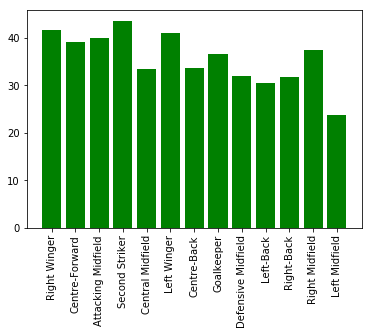

In [130]:
#Plotting a bar chart to show the relationship between the categorical variable and the numerical variable
plt.bar(x,y, color = 'green')
plt.xticks(rotation = 90)
plt.show()

In [131]:
footballData['newPosition'] = footballData.Position.map({'Right Winger':'Striker', 'Centre-Forward':'Striker', 'Attacking Midfield':'Midfielder',\
                                      'Second Striker':'Striker',\
                                 'Central Midfield':'Midfielder', 'Left Winger':'Striker', 'Centre-Back':'Defender', \
                                      'Goalkeeper':'Defender',  \
                                'Defensive Midfield':'Midfielder', 'Left-Back':'Defender', 'Right-Back':'Defender',\
                                      'Right Midfield':'Midfielder',\
                                 'Left Midfield':'Midfielder'})
footballData.newPosition.isnull().sum()

0

In [132]:
newPosition = footballData['newPosition']
marketValue = footballData['Market Value']
newPosMar = pd.concat((newPosition, marketValue), axis=1, ignore_index= True)
newPosMar = newPosMar.to_dict('split')
newListPosMar = newPosMar['data']
newListPosMar

[['Striker', 200],
 ['Striker', 160],
 ['Striker', 150],
 ['Midfielder', 150],
 ['Midfielder', 140],
 ['Striker', 110],
 ['Midfielder', 100],
 ['Striker', 100],
 ['Midfielder', 90],
 ['Striker', 80],
 ['Defender', 80],
 ['Midfielder', 80],
 ['Defender', 80],
 ['Striker', 180],
 ['Striker', 150],
 ['Striker', 150],
 ['Striker', 150],
 ['Striker', 120],
 ['Midfielder', 100],
 ['Striker', 100],
 ['Striker', 100],
 ['Striker', 85],
 ['Striker', 80],
 ['Striker', 80],
 ['Defender', 80],
 ['Midfielder', 80],
 ['Midfielder', 80],
 ['Striker', 75],
 ['Striker', 75],
 ['Midfielder', 75],
 ['Striker', 75],
 ['Striker', 70],
 ['Defender', 70],
 ['Defender', 70],
 ['Defender', 70],
 ['Defender', 70],
 ['Striker', 70],
 ['Defender', 65],
 ['Striker', 80],
 ['Midfielder', 75],
 ['Defender', 75],
 ['Midfielder', 75],
 ['Striker', 75],
 ['Striker', 70],
 ['Midfielder', 70],
 ['Midfielder', 70],
 ['Midfielder', 70],
 ['Defender', 70],
 ['Midfielder', 70],
 ['Midfielder', 70],
 ['Midfielder', 65],
 ['St

In [133]:
#Total market value for each position
newDicPosMar = {}
for i in range(len(newListPosMar)):
    if newListPosMar[i][0] in newDicPosMar.keys():
        newDicPosMar[newListPosMar[i][0]] += newListPosMar[i][1]
    else:
        newDicPosMar[newListPosMar[i][0]] = newListPosMar[i][1]
newDicPosMar

{'Striker': 7080, 'Midfielder': 5786, 'Defender': 5242}

In [134]:
#Total number of people in the sample per position
newNumPerPos = {}
for i in range(len(newListPosMar)):
    newNumPerPos.setdefault(newListPosMar[i][0], 0)
    newNumPerPos[newListPosMar[i][0]] += 1
newNumPerPos

{'Striker': 174, 'Midfielder': 168, 'Defender': 158}

In [135]:
#Average market value per position
newAveValPerPos = {}
newPosList = list(newDicPosMar.keys())
for i in range(len(list(newPosList))):
    newAveValPerPos.setdefault(newPosList[i], (newDicPosMar[newPosList[i]]/newNumPerPos[newPosList[i]]))
newAveValPerPos

{'Striker': 40.689655172413794,
 'Midfielder': 34.44047619047619,
 'Defender': 33.177215189873415}

In [136]:
newAveValPerPosList = []
for i in range(len(list(newAveValPerPos.keys()))):
    newTempList = []
    newTempList.append(list(newAveValPerPos.keys())[i])
    newTempList.append(list(newAveValPerPos.values())[i])
    newAveValPerPosList.append(newTempList)
newX = []
newY = []
for i in range(len(newAveValPerPosList)):
    newX.append(newAveValPerPosList[i][0])
    newY.append(newAveValPerPosList[i][1])
newX, newY

(['Striker', 'Midfielder', 'Defender'],
 [40.689655172413794, 34.44047619047619, 33.177215189873415])

<BarContainer object of 3 artists>

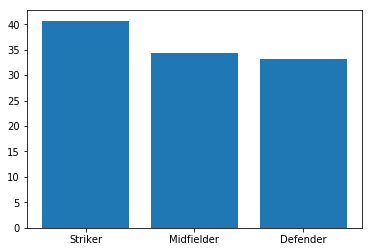

In [137]:
plt.bar(newX,newY)

In [138]:
footballData['newPosEncoded'] = footballData.newPosition.map({'Striker':2, 'Midfielder':1, 'Defender':0})

In [139]:
X = footballData.iloc[:,[1,3,4,5,6,7,8,9,10,11,13]].values
y = footballData.iloc[:, 2].values
X.shape,y.shape
type(y)

numpy.ndarray

In [140]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape,y_train.shape

((400, 11), (400,))

In [141]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)

In [142]:
regressor.score(X_train,y_train)

0.2565790346937935

In [150]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)  
#say out of 12 variables, select a model with 5 variables with the lowest mse
Z = footballData.iloc[:,[1,3,4,5,6,7,8,9,10,11,13]]
X.shape

(500, 15)

In [152]:
import statsmodels.formula.api as sm
sigLevel = 0.05
a,b = X.shape
#X = np.append(arr = np.ones((500,1)).astype(int), values = X, axis = 1)
X_opt = X[:,[0,1,2,3,4,5,6,7,8,9,10,11]]
X_opt = sm.add_constant(X_opt)
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
pVals = regressor_OLS.pvalues #returns a vector

index = ['constant','age','matches','goals','own goals','assists','yellow cards', 'second yellow card', 'red cards',\
             'substituted on', 'substituted off', 'position']
#print(np.argmax(pVals)) returns the indices of the maximum value along an axis
while pVals[np.argmax(pVals)] > sigLevel:
    X_opt = np.delete(X_opt, np.argmax(pVals), axis = 1)
    del index[np.argmax(pVals)]
    print('pVal deleted at index', index[np.argmax(pVals)], str(np.argmax(pVals)), '\n', str(X_opt.shape[1]), 'variables remaining')
    regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
    pVals = regressor_OLS.pvalues
    
regressor_OLS.summary()

AttributeError: module 'statsmodels.formula.api' has no attribute 'add_constant'

In [ ]:
#Normality of errors
residual = y_test - y_pred
residual = pd.Series(residual)
plt.scatter(y_pred, resid)

In [ ]:
#Independence of errors
plt.scatter(residual.index, residual.values)
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residual)

In [10]:
#Homoscedasticity
plt.scatter(y_pred, residual)

NameError: name 'y_pred' is not defined

In [11]:
#Detecting multicollinearity using VIF
#VIF = 1 / (1-R_squared)

In [ ]:
#Linearity - correct functional form